# Topic Modeling using LDA


### -Siddharth Suresh, MSDS' 20, UVA

Topic modeling can be described as the process of extracting abstract topics that occur in a collection of documents. It is a way to find out the latent topics based on the collection of words in the corpus.

One way to model this is using Latent Dirichlet Allocation (LDA). This method follows these simple steps:
1. Each document can be considered as a mixture of latent topics
2. Each topic can be considered as a mixture of words

Essentially, LDA helps in estimiating each of the above, i.e estimating a topic based on the words and further estimating the mixture of topics that describe a document. In order to set up the corpus for running an LDA model, there is some preprocessing required.

Will see more of all this subsequently.

**Index**

[1. Dataset](#dataset)

[2. Pre-processing](#preprocessing)

* [Stemming-Lemmatization](#stem/lemma)

* [Removing STOPWORDS](#stopwords)

[3. LDA Model](#model)

* [Bag of words](#bow)

* [TF-IDF](#tfidf)

[4. Topics within wine reviews](#wine)
    
    

In [3]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1024,
        'height': 768,
        'scroll': True,
})

{'width': 1024, 'height': 768, 'scroll': True}

## <a name="dataset"></a> Loading the dataset - News Articles

In [36]:
# required libraries

import pandas as pd # to work with dataframes
from wordcloud import WordCloud # to analyze frequency of different words in the corpus
import re # for using regular expressions
import matplotlib.pyplot as plt

# used for pre-processing the text data and unsupervised topic modeling
import gensim
from gensim import models
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.corpora import Dictionary

# used for natural language processing {NLTK: Natural Language Tool-Kit} 
from nltk.stem import WordNetLemmatizer, SnowballStemmer, LancasterStemmer
from nltk.stem.porter import *
import nltk
nltk.download('wordnet')

# Set a seed to reproduce the results later. Seed used here is '2019'
import numpy as np
np.random.seed(2019)

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/siddharth/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [28]:
pd.set_option('display.max_colwidth', -1)

# read in the csv file containing the news articles
news = pd.read_csv("abcnews-date-text.csv")
news

publish_date  \
0        20030219       
1        20030219       
2        20030219       
3        20030219       
4        20030219       
...           ...       
1103658  20171231       
1103659  20171231       
1103660  20171231       
1103661  20171231       
1103662  20171231       

                                                       headline_text  
0        aba decides against community broadcasting licence           
1        act fire witnesses must be aware of defamation               
2        a g calls for infrastructure protection summit               
3        air nz staff in aust strike for pay rise                     
4        air nz strike to affect australian travellers                
...                                                ...                
1103658  the ashes smiths warners near miss liven up boxing day test  
1103659  timelapse: brisbanes new year fireworks                      
1103660  what 2017 meant to the kids of australia                     
1103661  what the papodopoulos meeting may mean for ausus             
1103662  who is george papadopoulos the former trump campaign aide    

[1103663 rows x 2 columns]

The dataset has news article headlines from Australia's ABC News (a public news service). This dataset has 1,103,663 different news headlines along with the date of publication. For the purpose of our analysis, the date of publication isn't required. All we need is the text.

However, the other thing to note here is that each headline in itself isn't too long, i.e frequency of a word within a single document is going to be low. However, frequency of a word/term in the entire corpus would affect our model more than the frequency of a word/term within a document.

We will see how this affects our models.

In [29]:
news = news.drop(columns = "publish_date") # since this data isn't really required for the topic modeling
news['index'] = news.index # we would want to give each article an index to reference back to it later

news[500:520]

headline_text  index
500  committal continues into goulburn jail riot           500  
501  costello unhappy he wasnt consulted by stone          501  
502  council approves poultry farm                         502  
503  council awaits more rain                              503  
504  council considers indigenous caravan park plan        504  
505  council elections planned for may                     505  
506  council rejects combined field days stand idea        506  
507  council to change tree protection by law              507  
508  council to fund groundwater study                     508  
509  counsel begin summing up at warnes doping hearing     509  
510  criminal charges pending in south korea subway probe  510  
511  crocs prove too good for bullets                      511  
512  date set for bushfires coronial inquiry               512  
513  dean to receive lifetime parliamentary pension        513  
514  death spells end to record marriage                   514  
515  demons thump tigers                                   515  
516  deportivo cali outclass sulky river plate             516  
517  deschamps chases old flame marseille                  517  
518  disaster funds to allow shire to complete other       518  
519  dortmund ready to hound bayern                        519

Just from eyeballing this section of the data (rows 500 to 519), it can be observed that there are articles from politics, law, sports just to name a few. Let's see what we get from visualizing the words in these articles.

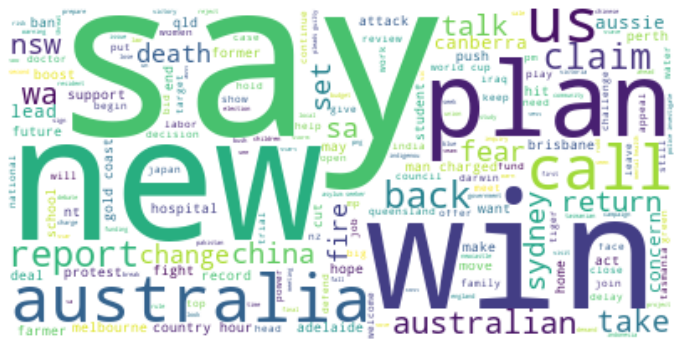

In [156]:
text = " ".join(headline for headline in news["headline_text"])

wordcloud = WordCloud(background_color="white").generate(text)
plt.figure(figsize = (12,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

We see that the most important words turn out to be "say", "win", "new", "us" etc. which are all forms of stopwords. This shows us why it is important to filter these out before running our model.

We do not wish to train our topic model based on words that do not give us any idea of the latent topics.

## <a name="preprocessing"></a> Data pre-processing

##### Pre-processing includes the following steps:

1. <font color="blue"> Stemming-lemmatization </font>: This step is required to extract the rootwords from a document. For instance, the root word for happiness is "happy"
2. <font color="blue"> Removing stopwords </font>: Stopwords are the most commonly used words in natural language. Examples: "The", "a", "is", "at", "which" etc.

#### <a name = "stem/lemma"></a> 1. Stemming-Lemmatization

There are many stemmers in the NLTK library.

Some of the frequently used stemmers are:
1. SnowballStemmer
2. LancasterStemmer
3. PorterStemmer

The lemmatizer in the NLTK library is: WordNetLemmatizer

Let's look at how these would work on different words.

In [6]:
# initializing the stemmer and lemmatizer
stemmer = LancasterStemmer() # using the LancasterStemmer
lemmatizer = WordNetLemmatizer()

In [7]:
# sample words to stem/lemmatize
sample_words = ['happiness', 'flies', 'workers', 'dogs', 'agreed', 'owned', 'humbled', 'meeting', 'helper', 
                'drinks', 'watching', 'traditional', 'politics', 'player', 'curator', 'better', 'best', 
                'cooker', 'cooking']

stems = [stemmer.stem(plural) for plural in sample_words] # stemming process
lemmas = [lemmatizer.lemmatize(plural) for plural in sample_words] # lemmatization process

pd.DataFrame(data = {'original word': sample_words, 'stemmed': stems, 'lemma': lemmas})

original word stemmed        lemma
0   happiness     happy   happiness  
1   flies         fli     fly        
2   workers       work    worker     
3   dogs          dog     dog        
4   agreed        agree   agreed     
5   owned         own     owned      
6   humbled       humbl   humbled    
7   meeting       meet    meeting    
8   helper        help    helper     
9   drinks        drink   drink      
10  watching      watch   watching   
11  traditional   tradit  traditional
12  politics      polit   politics   
13  player        play    player     
14  curator       cur     curator    
15  better        bet     better     
16  best          best    best       
17  cooker        cook    cooker     
18  cooking       cook    cooking

From the dataframe above the following observations were made:
1. For some words, the lemmatization and stemming provide the exact same result (eg: "dogs", "drinks")
2. Lemmatization does not change certain words (eg: "agreed", "player", "watcher")
3. Stemming converts certain words to something that does not seem to be a word anymore (eg: "better", "curator", "politics", "traditional")

##### <font color = "black"> Q. There is an argument in the WordNetLemmatizer.lemmatize() called "pos" which stands for Part-of-speech. Do you think that could make a difference for the lemmatization process for the words given above? </font>

Note: by default, the "pos" argument is equal to "n"

where, n stands for NOUN

In [9]:
# lemmatization process (pos = "verb")
lemma_v = [lemmatizer.lemmatize(plural, pos = "v") for plural in sample_words]

# lemmatization process (pos = "verb")
lemma_a = [lemmatizer.lemmatize(plural, pos = "a") for plural in sample_words]

# saves the results in a dictionary and creates a dataframe from it
pd.DataFrame(data = {'original word': sample_words, 'stemmed': stems, 'lemma-noun': lemmas, 'lemma-verb': lemma_v,
                    'lemma-adjective': lemma_a})

original word stemmed   lemma-noun   lemma-verb lemma-adjective
0   happiness     happy   happiness    happiness    happiness     
1   flies         fli     fly          fly          flies         
2   workers       work    worker       workers      workers       
3   dogs          dog     dog          dog          dogs          
4   agreed        agree   agreed       agree        agreed        
5   owned         own     owned        own          owned         
6   humbled       humbl   humbled      humble       humbled       
7   meeting       meet    meeting      meet         meeting       
8   helper        help    helper       helper       helper        
9   drinks        drink   drink        drink        drinks        
10  watching      watch   watching     watch        watching      
11  traditional   tradit  traditional  traditional  traditional   
12  politics      polit   politics     politics     politics      
13  player        play    player       player       player        
14  curator       cur     curator      curator      curator       
15  better        bet     better       better       good          
16  best          best    best         best         best          
17  cooker        cook    cooker       cooker       cooker        
18  cooking       cook    cooking      cook         cooking

So, which part-of-speech argument should be used for this problem?

For this case, since we are modeling topics for a corpus of news articles, using verbs for the part-of-speech argument does seem to be intuitive. This is because we want to associate the articles to different topics based on the words we observe in a cluster of documents.

For instance, if we observe the words "cook", "chef", "vegetables", "restaurant", "soup", "wine" as the most commonly occuring words, we would want to choose a topic such as say "CULINARY NEWS" in the context of news articles.

So, in order to get the right root, we might want to extract the root based on the part of speech being set to "verb".

Another way could be to stem the resultant lemmatized word. You will see a lot of people use a combination of these methods to extract the roots, but for this analysis, I shall be using the lemmas only. You can see the result below when lemmatization was used with pos = "v"

In [10]:
# combined lemmatization and stemming process (in that order)
stem_lemma = [stemmer.stem(WordNetLemmatizer().lemmatize(plural, pos = "v")) for plural in sample_words]

pd.DataFrame(data = {'original word': sample_words, 'stemmed': stems, 'lemma-verb': lemma_v,
                    'stem-lemma': stem_lemma})

original word stemmed   lemma-verb stem-lemma
0   happiness     happy   happiness    happy    
1   flies         fli     fly          fly      
2   workers       work    workers      work     
3   dogs          dog     dog          dog      
4   agreed        agree   agree        agr      
5   owned         own     own          own      
6   humbled       humbl   humble       humbl    
7   meeting       meet    meet         meet     
8   helper        help    helper       help     
9   drinks        drink   drink        drink    
10  watching      watch   watch        watch    
11  traditional   tradit  traditional  tradit   
12  politics      polit   politics     polit    
13  player        play    player       play     
14  curator       cur     curator      cur      
15  better        bet     better       bet      
16  best          best    best         best     
17  cooker        cook    cooker       cook     
18  cooking       cook    cook         cook

Based on the dataframe above, I would prefer the lemma-verb column more than the others.

Let's now define a function that lemmatizes given word:

In [11]:
# function to lemmatize a given word

def lemmatize(text):
    return lemmatizer.lemmatize(text, pos = "v")

#### <a name = "stopwords"></a> 2. Removing stopwords

Stopwords can be removed from text by comparing individual words in a sentence with a defined list of STOPWORDS. The STOPWORDS from gensim.parsing.preprocessing library has a list of such stopwords in the english language.

In [12]:
# stopwords in the list
gensim.parsing.preprocessing.STOPWORDS

frozenset({'a',
           'about',
           'above',
           'across',
           'after',
           'afterwards',
           'again',
           'against',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'are',
           'around',
           'as',
           'at',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
           'behind',
           'being',
           'below',
           'beside',
           'besides'

Let's look at how it works for a few sentences:

In [13]:
sentence1 = "We are trying to learn how to implement topic modeling using LDA"
sentence2 = "This is a sample sentence to check how to remove stopwords from a sentence"

First, we shall tokenize the above sentences and then compare it with the stopwords. In order to do that, we will use the gensim.utils.simple_preprocess() function. Let's try that:

In [14]:
print(gensim.utils.simple_preprocess(sentence1))
print(gensim.utils.simple_preprocess(sentence2))

['we', 'are', 'trying', 'to', 'learn', 'how', 'to', 'implement', 'topic', 'modeling', 'using', 'lda']
['this', 'is', 'sample', 'sentence', 'to', 'check', 'how', 'to', 'remove', 'stopwords', 'from', 'sentence']


The tokenization works, so next let's try to remove all the stopwords from each of the sentences.

In [15]:
# initializing two empty lists for each of the sentences
res1 = []
res2 = []

for word in gensim.utils.simple_preprocess(sentence1):
    if word not in gensim.parsing.preprocessing.STOPWORDS and len(word) > 3:
        res1.append(word)
        
for word in gensim.utils.simple_preprocess(sentence2):
    if word not in gensim.parsing.preprocessing.STOPWORDS and len(word) > 3:
        res2.append(word)

print(res1)
print(res2)

# Note that we also checked for the length of the words along with removing stopwords

['trying', 'learn', 'implement', 'topic', 'modeling']
['sample', 'sentence', 'check', 'remove', 'stopwords', 'sentence']


Now that we have a way to remove the stopwords, we can combine the two processes of stemming/lemmatization and removing stopwords and define a function to help us do this

In [20]:
# function to preprocess the text

def preprocess(text):
    result = []
    for word in gensim.utils.simple_preprocess(text):
        if word not in gensim.parsing.preprocessing.STOPWORDS and len(word) > 3:
            l = lemmatize(word)
            if len(l) > 3:
                result.append(l)
    return result

Let's see how this works for the news article at index = 500 from the data frame above that had the headline "<font color = "red">committal continues into goulburn jail riot</font>"

In [21]:
preprocess(news.iloc[500,0])

['committal', 'continue', 'goulburn', 'jail', 'riot']

It works!!! Now we can implement this preprocessing function over the entire data we have.

In [22]:
processed_news = news['headline_text'].map(preprocess)

In [19]:
processed_news[500:520]

500    [committal, continue, goulburn, jail, riot]             
501    [costello, unhappy, wasnt, consult, stone]              
502    [council, approve, poultry, farm]                       
503    [council, await, rain]                                  
504    [council, consider, indigenous, caravan, park, plan]    
505    [council, elections, plan]                              
506    [council, reject, combine, field, days, stand, idea]    
507    [council, change, tree, protection]                     
508    [council, fund, groundwater, study]                     
509    [counsel, begin, warn, dope, hear]                      
510    [criminal, charge, pending, south, korea, subway, probe]
511    [crocs, prove, good, bullets]                           
512    [date, bushfires, coronial, inquiry]                    
513    [dean, receive, lifetime, parliamentary, pension]       
514    [death, spell, record, marriage]                        
515    [demons, thump, tigers]          

Let's now see if the visualization of words from the pre-processed text shows us something different

In [157]:
text = " ".join(word for i in range(0, len(processed_news)) for word in processed_news[i])

wordcloud = WordCloud(background_color="white").generate(text)
plt.figure(figsize = (12,12))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()

## <a name = "model"></a> Modeling

In order to model, we will try to examine these approaches:
1. LDA using bag of words
2. LDA using TF-IDF

### Bag of words

This method uses frequency of occurence of words in the corpus as a feature. The bag of words approach uses the following:
1. Vocabulary of known words (dictionary)
2. A measure of presence/occurence of words from the vocabulary

Since topic modeling algorithms cannot deal with raw text directly, it needs to be converted to vector of numbers. This is what the bag of words approach helps us achieve.

In [30]:
# creates a dictionary of unique words from the corpus
dictionary = Dictionary(processed_news)

In [31]:
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 broadcast
1 community
2 decide
3 licence
4 aware
5 defamation
6 witness
7 call
8 infrastructure
9 protection
10 summit


In [32]:
# these are the number of unique words identified from the pre-processed news articles
len(dictionary)

77409

Given that there are about 1.1 million articles in the dataset, the number of unique words that would be used for modeling still seem to be high. In order for us to filter this out further, we will try to remove the following type of words:
1. All of the words that appear in less than 'x' number of the articles
2. All of the words that appear in more than 'y%' of the articles

In order to select the values of x and y, we will inspect our dictionary.

In [39]:
# document frequencies

words_in_articles = pd.DataFrame.from_dict(dictionary.dfs, orient = 'index', columns = ["number of documents"])
words_in_articles.sort_values("number of documents", ascending = False, inplace = True)

list1 = words_in_articles.index

words_freq = {}
for i in list1:
    words_freq[dictionary[i]] = words_in_articles['number of documents'][i]

words_in_articles['word'] = words_freq.keys()
words_in_articles

number of documents        word
238    36127                police    
47     22403                plan      
323    19267                charge    
165    16922                govt      
213    16727                court     
...      ...                  ...     
50384  1                    hallahan  
50383  1                    dazy      
50382  1                    blakefield
50380  1                    blechynden
77407  1                    ausus     

[77409 rows x 2 columns]

In [44]:
# filter the extremes
dictionary.filter_extremes(no_below = 200, no_above = 0.5)

len(dictionary)

3588

Now that we've reduced our dictionary to 3,588 unique words, the model should be able to provide us highly specific words to interpret the topic.

In [45]:
bag_of_words = [dictionary.doc2bow(news) for news in processed_news]

This method of converting the documents into vectors is what we shall use as input to the LDA model algorithm. 

The LDA model can be run with the function models.LdaMulticore() which is available in the **gensim** library. The parameters it uses are:
1. The bag-of-words vector
2. The number of latent topics we wish to extract from this model
3. A dictionary of the known vocabulary from the corpus
4. Number of passes you wish to make over the entire corpus to fit the model (Note: by default passes = 1, anything more may give you a better result but may be computationally more expensive)
5. Number of cores you want to run it on for parallelization (optimal performance will be on {number of cores - 1})

In [62]:
# LDA model using the bag-of-words

lda_model_bow = models.LdaMulticore(bag_of_words, num_topics=10, id2word=dictionary, passes=2, workers=1)

Let's see the topics we got based on our LDA model.

In [63]:
# topics we got from our LDA model

for idx, topic in lda_model_bow.print_topics(-1):
    print('Topic: {} \nWords: {}\n'.format(idx, topic))

Topic: 0 
Words: 0.043*"court" + 0.027*"canberra" + 0.027*"face" + 0.020*"people" + 0.020*"labor" + 0.017*"water" + 0.017*"marriage" + 0.014*"indigenous" + 0.014*"hear" + 0.013*"rural"

Topic: 1 
Words: 0.035*"queensland" + 0.032*"attack" + 0.028*"kill" + 0.027*"south" + 0.019*"miss" + 0.018*"china" + 0.016*"tasmania" + 0.016*"deal" + 0.016*"interview" + 0.015*"lose"

Topic: 2 
Words: 0.030*"donald" + 0.026*"warn" + 0.022*"turnbull" + 0.020*"drug" + 0.020*"arrest" + 0.017*"final" + 0.017*"tell" + 0.016*"trial" + 0.014*"australias" + 0.013*"christmas"

Topic: 3 
Words: 0.037*"charge" + 0.027*"murder" + 0.024*"home" + 0.023*"woman" + 0.021*"years" + 0.020*"jail" + 0.018*"accuse" + 0.018*"child" + 0.017*"help" + 0.017*"leave"

Topic: 4 
Words: 0.059*"trump" + 0.047*"australian" + 0.028*"adelaide" + 0.025*"perth" + 0.024*"crash" + 0.024*"election" + 0.024*"report" + 0.022*"open" + 0.017*"time" + 0.017*"family"

Topic: 5 
Words: 0.041*"sydney" + 0.039*"government" + 0.027*"school" + 0.020*"

**Could you identify a topic to allocate to some of these topics?**

In [65]:
# I am defining a function to gives us the actual headline and the associated processed list
def show_headline(n):
    print(news.headline_text[n])
    print(processed_news[n])

In [89]:
# we will use these to check which topics get allotted: 507, 508, 509, 510
t = bag_of_words[507]
show_headline(507)

council to change tree protection by law
['council', 'change', 'tree', 'protection']


In [90]:
for index, score in sorted(lda_model_bow[t], key = lambda x: -1*x[1]):
    print("\nScore: {}\t \nTopic: {}\n".format(score, lda_model_bow.print_topic(index, 10)))


Score: 0.6200054287910461	 
Topic: 0.024*"change" + 0.021*"live" + 0.020*"state" + 0.019*"health" + 0.017*"call" + 0.016*"fund" + 0.014*"meet" + 0.013*"case" + 0.012*"want" + 0.012*"game"


Score: 0.21998025476932526	 
Topic: 0.024*"year" + 0.022*"melbourne" + 0.021*"market" + 0.019*"tasmanian" + 0.018*"hospital" + 0.016*"show" + 0.015*"share" + 0.014*"country" + 0.014*"fall" + 0.013*"price"


Score: 0.020006824284791946	 
Topic: 0.041*"sydney" + 0.039*"government" + 0.027*"school" + 0.020*"death" + 0.016*"take" + 0.016*"service" + 0.015*"national" + 0.014*"victoria" + 0.014*"flood" + 0.013*"park"


Score: 0.02000107243657112	 
Topic: 0.043*"court" + 0.027*"canberra" + 0.027*"face" + 0.020*"people" + 0.020*"labor" + 0.017*"water" + 0.017*"marriage" + 0.014*"indigenous" + 0.014*"hear" + 0.013*"rural"


Score: 0.02000107243657112	 
Topic: 0.035*"queensland" + 0.032*"attack" + 0.028*"kill" + 0.027*"south" + 0.019*"miss" + 0.018*"china" + 0.016*"tasmania" + 0.016*"deal" + 0.016*"interview

We can see that the LDA model using bag of words, definitely allocates topics in the way we expect it to for most of the examples with a high probability.

However, let's see if this could work for predictions on external news articles.

In [91]:
unseen_news = "Australia bushfires: New South Wales battles catastrophic conditions"
bow = dictionary.doc2bow(preprocess(unseen_news))

for index, score in sorted(lda_model_bow[bow], key = lambda x: -1*x[1]):
    print("\nScore: {}\t \nTopic: {}\n".format(score, lda_model_bow.print_topic(index, 10)))


Score: 0.299998939037323	 
Topic: 0.030*"donald" + 0.026*"warn" + 0.022*"turnbull" + 0.020*"drug" + 0.020*"arrest" + 0.017*"final" + 0.017*"tell" + 0.016*"trial" + 0.014*"australias" + 0.013*"christmas"


Score: 0.1571679562330246	 
Topic: 0.057*"australia" + 0.028*"police" + 0.027*"world" + 0.026*"house" + 0.019*"shoot" + 0.016*"women" + 0.015*"test" + 0.015*"league" + 0.013*"guilty" + 0.012*"island"


Score: 0.1571647673845291	 
Topic: 0.035*"queensland" + 0.032*"attack" + 0.028*"kill" + 0.027*"south" + 0.019*"miss" + 0.018*"china" + 0.016*"tasmania" + 0.016*"deal" + 0.016*"interview" + 0.015*"lose"


Score: 0.15715353190898895	 
Topic: 0.041*"sydney" + 0.039*"government" + 0.027*"school" + 0.020*"death" + 0.016*"take" + 0.016*"service" + 0.015*"national" + 0.014*"victoria" + 0.014*"flood" + 0.013*"park"


Score: 0.15707345306873322	 
Topic: 0.043*"court" + 0.027*"canberra" + 0.027*"face" + 0.020*"people" + 0.020*"labor" + 0.017*"water" + 0.017*"marriage" + 0.014*"indigenous" + 0.01

In [92]:
unseen_news = "Scientists develop a new method for identifying potentially habitable planets that could host \
                ALIEN LIFE outside of our solar system"
bow = dictionary.doc2bow(preprocess(unseen_news))

for index, score in sorted(lda_model_bow[bow], key = lambda x: -1*x[1]):
    print("\nScore: {}\t \nTopic: {}\n".format(score, lda_model_bow.print_topic(index, 10)))


Score: 0.2625325620174408	 
Topic: 0.037*"charge" + 0.027*"murder" + 0.024*"home" + 0.023*"woman" + 0.021*"years" + 0.020*"jail" + 0.018*"accuse" + 0.018*"child" + 0.017*"help" + 0.017*"leave"


Score: 0.26253223419189453	 
Topic: 0.043*"court" + 0.027*"canberra" + 0.027*"face" + 0.020*"people" + 0.020*"labor" + 0.017*"water" + 0.017*"marriage" + 0.014*"indigenous" + 0.014*"hear" + 0.013*"rural"


Score: 0.1375003606081009	 
Topic: 0.033*"north" + 0.026*"coast" + 0.025*"brisbane" + 0.020*"high" + 0.019*"record" + 0.017*"break" + 0.017*"west" + 0.016*"gold" + 0.015*"vote" + 0.013*"young"


Score: 0.13748568296432495	 
Topic: 0.035*"queensland" + 0.032*"attack" + 0.028*"kill" + 0.027*"south" + 0.019*"miss" + 0.018*"china" + 0.016*"tasmania" + 0.016*"deal" + 0.016*"interview" + 0.015*"lose"


Score: 0.13743413984775543	 
Topic: 0.041*"sydney" + 0.039*"government" + 0.027*"school" + 0.020*"death" + 0.016*"take" + 0.016*"service" + 0.015*"national" + 0.014*"victoria" + 0.014*"flood" + 0.01

### TF-IDF

This method helps with the problem that highly frequent words start to dominate in the document but may potentially not contain as much "informational content" on the latent topic.

It has two components:
1. Term Frequency (TF): scores the frequency of a word in the document
2. Inverse Document Frequency(IDF): scores how rare a word is across documents.

So essentially, it is scoring the frequency of the word in a given document but offsetting it by how rare the word is in the corpus. Let's try to build an LDA model using tf-idf corpus.

In [99]:
# building a tf-idf corpus from the bag of words created earlier

tfidf = models.TfidfModel(bag_of_words)
corpus_tfidf = tfidf[bag_of_words]

In [100]:
# LDA model using the tf-idf corpus

lda_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=1)

Let's see the topics we get with the LDA model using tf-idf

In [103]:
for idx, topic in lda_tfidf.print_topics(-1):
    print('Topic: {} \nWords: {}\n'.format(idx, topic))

Topic: 0 
Words: 0.022*"turnbull" + 0.018*"tasmania" + 0.018*"miss" + 0.017*"show" + 0.015*"malcolm" + 0.013*"search" + 0.012*"world" + 0.012*"near" + 0.011*"body" + 0.011*"battle"

Topic: 1 
Words: 0.035*"queensland" + 0.019*"women" + 0.014*"young" + 0.013*"aboriginal" + 0.012*"mother" + 0.012*"parliament" + 0.012*"australians" + 0.011*"know" + 0.010*"play" + 0.010*"season"

Topic: 2 
Words: 0.025*"years" + 0.017*"break" + 0.015*"news" + 0.015*"city" + 0.013*"state" + 0.013*"mark" + 0.012*"announce" + 0.011*"citizenship" + 0.011*"come" + 0.010*"year"

Topic: 3 
Words: 0.057*"trump" + 0.014*"league" + 0.014*"country" + 0.013*"australias" + 0.012*"john" + 0.012*"election" + 0.012*"hobart" + 0.011*"star" + 0.010*"turn" + 0.010*"race"

Topic: 4 
Words: 0.022*"live" + 0.014*"week" + 0.011*"million" + 0.011*"test" + 0.010*"speak" + 0.010*"western" + 0.010*"womens" + 0.010*"senate" + 0.009*"right" + 0.009*"australia"

Topic: 5 
Words: 0.027*"government" + 0.016*"coast" + 0.016*"market" + 0.0

In [110]:
# we will use these to check which topics get allotted: 507, 508, 509, 510
t = bag_of_words[510]
show_headline(510)

criminal charges pending in south korea subway probe
['criminal', 'charge', 'pending', 'south', 'korea', 'subway', 'probe']


In [111]:
for index, score in sorted(lda_tfidf[t], key = lambda x: -1*x[1]):
    print("\nScore: {}\t \nTopic: {}\n".format(score, lda_tfidf.print_topic(index, 10)))


Score: 0.3995852470397949	 
Topic: 0.016*"people" + 0.014*"power" + 0.013*"adelaide" + 0.012*"korea" + 0.011*"north" + 0.010*"park" + 0.008*"station" + 0.008*"farm" + 0.008*"premier" + 0.008*"protest"


Score: 0.2542281448841095	 
Topic: 0.019*"charge" + 0.018*"murder" + 0.017*"police" + 0.015*"court" + 0.015*"woman" + 0.014*"crash" + 0.012*"shoot" + 0.012*"death" + 0.011*"interview" + 0.011*"perth"


Score: 0.22949931025505066	 
Topic: 0.020*"marriage" + 0.018*"life" + 0.017*"child" + 0.015*"victoria" + 0.013*"abuse" + 0.013*"energy" + 0.010*"president" + 0.010*"kill" + 0.010*"sport" + 0.010*"drive"


Score: 0.01667596958577633	 
Topic: 0.027*"government" + 0.016*"coast" + 0.016*"market" + 0.015*"tasmanian" + 0.014*"south" + 0.012*"west" + 0.012*"bank" + 0.012*"share" + 0.011*"gold" + 0.011*"christmas"


Score: 0.016668548807501793	 
Topic: 0.022*"turnbull" + 0.018*"tasmania" + 0.018*"miss" + 0.017*"show" + 0.015*"malcolm" + 0.013*"search" + 0.012*"world" + 0.012*"near" + 0.011*"body

Now, let's see how well this works for predictions on external news articles.

In [112]:
unseen_news = "Australia bushfires: New South Wales battles catastrophic conditions"
bow = dictionary.doc2bow(preprocess(unseen_news))

for index, score in sorted(lda_tfidf[bow], key = lambda x: -1*x[1]):
    print("\nScore: {}\t \nTopic: {}\n".format(score, lda_tfidf.print_topic(index, 10)))


Score: 0.3000269830226898	 
Topic: 0.022*"turnbull" + 0.018*"tasmania" + 0.018*"miss" + 0.017*"show" + 0.015*"malcolm" + 0.013*"search" + 0.012*"world" + 0.012*"near" + 0.011*"body" + 0.011*"battle"


Score: 0.22453366219997406	 
Topic: 0.029*"donald" + 0.015*"drum" + 0.013*"children" + 0.013*"record" + 0.012*"street" + 0.012*"island" + 0.011*"rise" + 0.009*"quiz" + 0.009*"fall" + 0.009*"festival"


Score: 0.20738863945007324	 
Topic: 0.027*"government" + 0.016*"coast" + 0.016*"market" + 0.015*"tasmanian" + 0.014*"south" + 0.012*"west" + 0.012*"bank" + 0.012*"share" + 0.011*"gold" + 0.011*"christmas"


Score: 0.18231205642223358	 
Topic: 0.020*"marriage" + 0.018*"life" + 0.017*"child" + 0.015*"victoria" + 0.013*"abuse" + 0.013*"energy" + 0.010*"president" + 0.010*"kill" + 0.010*"sport" + 0.010*"drive"


Score: 0.014290641993284225	 
Topic: 0.016*"people" + 0.014*"power" + 0.013*"adelaide" + 0.012*"korea" + 0.011*"north" + 0.010*"park" + 0.008*"station" + 0.008*"farm" + 0.008*"premier"

In [113]:
unseen_news = "Scientists develop a new method for identifying potentially habitable planets that could host \
                ALIEN LIFE outside of our solar system"
bow = dictionary.doc2bow(preprocess(unseen_news))

for index, score in sorted(lda_tfidf[bow], key = lambda x: -1*x[1]):
    print("\nScore: {}\t \nTopic: {}\n".format(score, lda_tfidf.print_topic(index, 10)))


Score: 0.26254862546920776	 
Topic: 0.022*"turnbull" + 0.018*"tasmania" + 0.018*"miss" + 0.017*"show" + 0.015*"malcolm" + 0.013*"search" + 0.012*"world" + 0.012*"near" + 0.011*"body" + 0.011*"battle"


Score: 0.13752812147140503	 
Topic: 0.020*"marriage" + 0.018*"life" + 0.017*"child" + 0.015*"victoria" + 0.013*"abuse" + 0.013*"energy" + 0.010*"president" + 0.010*"kill" + 0.010*"sport" + 0.010*"drive"


Score: 0.13750049471855164	 
Topic: 0.035*"queensland" + 0.019*"women" + 0.014*"young" + 0.013*"aboriginal" + 0.012*"mother" + 0.012*"parliament" + 0.012*"australians" + 0.011*"know" + 0.010*"play" + 0.010*"season"


Score: 0.13749490678310394	 
Topic: 0.025*"years" + 0.017*"break" + 0.015*"news" + 0.015*"city" + 0.013*"state" + 0.013*"mark" + 0.012*"announce" + 0.011*"citizenship" + 0.011*"come" + 0.010*"year"


Score: 0.13748350739479065	 
Topic: 0.029*"donald" + 0.015*"drum" + 0.013*"children" + 0.013*"record" + 0.012*"street" + 0.012*"island" + 0.011*"rise" + 0.009*"quiz" + 0.009*"

How do these models work when the document length is large? Let's find out using a dataset for wine reviews.

## <a name = "wine"></a> Wine reviews - Topic modeling

This dataset has 118,840 wine reviews of different kinds of wine. Since wine reviews are usually quite verbose and the fact that the words used for description are quite frequent, it might be interesting what we find as the latent topics for these reviews. Let's dive in!

In [116]:
# loading the data set
wines = pd.read_csv("wines.csv")
wines

wine_id  \
0       0         
1       1         
2       2         
3       3         
4       4         
...    ..         
118835  129966    
118836  129967    
118837  129968    
118838  129969    
118839  129970    

                                                                                                        title  \
0       Nicosia 2013 Vulkà Bianco  (Etna)                                                                       
1       Quinta dos Avidagos 2011 Avidagos Red (Douro)                                                           
2       Rainstorm 2013 Pinot Gris (Willamette Valley)                                                           
3       St. Julian 2013 Reserve Late Harvest Riesling (Lake Michigan Shore)                                     
4       Sweet Cheeks 2012 Vintner's Reserve Wild Child Block Pinot Noir (Willamette Valley)                     
...                                                                                     ...                     
118835  Dr. H. Thanisch (Erben Müller-Burggraef) 2013 Brauneberger Juffer-Sonnenuhr Spätlese Riesling (Mosel)   
118836  Citation 2004 Pinot Noir (Oregon)                                                                       
118837  Domaine Gresser 2013 Kritt Gewurztraminer (Alsace)                                                      
118838  Domaine Marcel Deiss 2012 Pinot Gris (Alsace)                                                           
118839  Domaine Schoffit 2012 Lieu-dit Harth Cuvée Caroline Gewurztraminer (Alsace)                             

                                                                                                                                                                                                                                                      description  \
0       Aromas include tropical fruit, broom, brimstone and dried herb. The palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity.                                                                                
1       This is ripe and fruity, a wine that is smooth while still structured. Firm tannins are filled out with juicy red berry fruits and freshened with acidity. It's  already drinkable, although it will certainly be better from 2016.                         
2       Tart and snappy, the flavors of lime flesh and rind dominate. Some green pineapple pokes through, with crisp acidity underscoring the flavors. The wine was all stainless-steel fermented.                                                                  
3       Pineapple rind, lemon pith and orange blossom start off the aromas. The palate is a bit more opulent, with notes of honey-drizzled guava and mango giving way to a slightly astringent, semidry finish.                                                     
4       Much like the regular bottling from 2012, this comes across as rather rough and tannic, with rustic, earthy, herbal characteristics. Nonetheless, if you think of it as a pleasantly unfussy country wine, it's a good companion to a hearty winter stew.   
...                                                                                                                                                                                                                                                           ...   
118835  Notes of honeysuckle and cantaloupe sweeten this deliciously feather-light spätlese. It's intensely juicy, quenching the palate with streams of tart tangerine and grapefruit acidity, yet wraps up with a kiss of honey and peach.                         
118836  Citation is given as much as a decade of bottle age prior to release, which means it is pre-cellared and drinking at its peak. Baked cherry, cocoa and coconut flavors combine gracefully, with soft, secondary fruit compote highlights.                   
118837  Well-drained gravel soil gives this wine its crisp and dry charac

In [117]:
# all columns except description could be dropped
wines = pd.DataFrame(wines['description'])
wines['index'] = wines.index
wines

description  \
0       Aromas include tropical fruit, broom, brimstone and dried herb. The palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity.                                                                                
1       This is ripe and fruity, a wine that is smooth while still structured. Firm tannins are filled out with juicy red berry fruits and freshened with acidity. It's  already drinkable, although it will certainly be better from 2016.                         
2       Tart and snappy, the flavors of lime flesh and rind dominate. Some green pineapple pokes through, with crisp acidity underscoring the flavors. The wine was all stainless-steel fermented.                                                                  
3       Pineapple rind, lemon pith and orange blossom start off the aromas. The palate is a bit more opulent, with notes of honey-drizzled guava and mango giving way to a slightly astringent, semidry finish.                                                     
4       Much like the regular bottling from 2012, this comes across as rather rough and tannic, with rustic, earthy, herbal characteristics. Nonetheless, if you think of it as a pleasantly unfussy country wine, it's a good companion to a hearty winter stew.   
...                                                                                                                                                                                                                                                           ...   
118835  Notes of honeysuckle and cantaloupe sweeten this deliciously feather-light spätlese. It's intensely juicy, quenching the palate with streams of tart tangerine and grapefruit acidity, yet wraps up with a kiss of honey and peach.                         
118836  Citation is given as much as a decade of bottle age prior to release, which means it is pre-cellared and drinking at its peak. Baked cherry, cocoa and coconut flavors combine gracefully, with soft, secondary fruit compote highlights.                   
118837  Well-drained gravel soil gives this wine its crisp and dry character. It is ripe and fruity, although the spice is subdued in favor of a more serious structure. This is a wine to age for a couple of years, so drink from 2017.                           
118838  A dry style of Pinot Gris, this is crisp with some acidity. It also has weight and a solid, powerful core of spice and baked apple flavors. With its structure still developing, the wine needs to age. Drink from 2015.                                    
118839  Big, rich and off-dry, this is powered by intense spiciness and rounded texture. Lychees dominate the fruit profile, giving an opulent feel to the aftertaste. Drink now.                                                                                   

         index  
0       0       
1       1       
2       2       
3       3       
4       4       
...    ..       
118835  118835  
118836  118836  
118837  118837  
118838  118838  
118839  118839  

[118840 rows x 2 columns]

In [119]:
# pre-processing the data

processed_wines = wines['description'].map(preprocess)
processed_wines[1000:1020]

1000    [nerello, mascalese, grape, native, volcanic, slop, mount, etna, deliver, fresh, berry, note, recall, raspberry, blueberry, mulberry, back, toast, almond, pretty, mineral, nuances, weave, texture, wine, polish, tannins, menthol, freshness, months, hardly, taste, wood]        
1001    [aromas, cherry, spice, mint, lead, tart, cherry, wild, berry, fruit, dust, cocoa, spice, months, french, barrel, unusual, high, pinots, seal, screwcap]                                                                                                                            
1002    [richness, vintage, show, wine, layer, fruit, sweet, tannins, dense, concentration, licorice, flavor, arrive, wine, mature]                                                                                                                                                         
1003    [firm, white, wine, give, good, green, fruit, pear, flavor, lift, spice, wood, wine, round, retain, crispness, grassy, acidity, offer, go

In [129]:
# creating a dictionary
wine_dict = Dictionary(processed_wines)
len(wine_dict)

24351

In [125]:
words_in_reviews = pd.DataFrame.from_dict(wine_dict.dfs, orient = 'index', columns = ["number of documents"])
words_in_reviews.sort_values("number of documents", ascending = False, inplace = True)

list2 = words_in_reviews.index

freq = {}
for i in list2:
    freq[wine_dict[i]] = words_in_reviews['number of documents'][i]

words_in_reviews['word'] = freq.keys()

words_in_reviews[0:15]

number of documents     word
35   59857                flavor 
31   59119                wine   
9    50818                fruit  
50   36599                finish 
3    35607                aromas 
14   34178                palate 
0    30909                acidity
125  30675                drink  
30   27464                tannins
156  25120                cherry 
27   23327                ripe   
154  22428                black  
56   21299                note   
114  20454                spice  
18   16247                berry

In [131]:
# filtering out extremes

wine_dict.filter_extremes(50, 0.5)
len(wine_dict)

2986

In [135]:
# bag-of-words for wine reviews
bow_wines = [wine_dict.doc2bow(review) for review in processed_wines]

# tfidf for wine reviews
tfidf_wines = models.TfidfModel(bow_wines)
corpus_wines = tfidf_wines[bow_wines]

In [137]:
# lda model with bag of words approach
lda_wine_bow = models.LdaMulticore(bow_wines, num_topics=10, id2word=wine_dict, passes=1, workers=1)

In [138]:
# lda model with tfidf approach
lda_wine_tfidf = models.LdaMulticore(corpus_wines, num_topics=10, id2word=wine_dict, passes=1, workers=1)

Let's examine the topics we get from each of the models:

In [139]:
# LDA with bow
print("LDA with bow\n")
for idx, topic in lda_wine_bow.print_topics(-1):
    print('Topic: {} \nWords: {}\n'.format(idx, topic))

print("\n")
    
# LDA with tfidf
print("LDA with tfidf\n")
for idx, topic in lda_wine_tfidf.print_topics(-1):
    print('Topic: {} \nWords: {}\n'.format(idx, topic))

LDA with bow

Topic: 0 
Words: 0.024*"fruit" + 0.023*"black" + 0.018*"nose" + 0.018*"palate" + 0.017*"wine" + 0.015*"bottle" + 0.014*"cherry" + 0.014*"vineyard" + 0.011*"finish" + 0.010*"show"

Topic: 1 
Words: 0.083*"wine" + 0.045*"acidity" + 0.043*"fruit" + 0.040*"drink" + 0.029*"ripe" + 0.021*"fruity" + 0.019*"texture" + 0.019*"character" + 0.019*"crisp" + 0.016*"rich"

Topic: 2 
Words: 0.029*"pinot" + 0.027*"wine" + 0.026*"cherry" + 0.020*"drink" + 0.017*"sweet" + 0.016*"noir" + 0.016*"good" + 0.015*"cherries" + 0.012*"like" + 0.012*"soft"

Topic: 3 
Words: 0.040*"finish" + 0.030*"palate" + 0.024*"note" + 0.017*"body" + 0.016*"fruit" + 0.016*"nose" + 0.013*"aromas" + 0.012*"medium" + 0.012*"fresh" + 0.012*"apple"

Topic: 4 
Words: 0.037*"palate" + 0.037*"cherry" + 0.036*"tannins" + 0.033*"aromas" + 0.032*"black" + 0.020*"offer" + 0.018*"spice" + 0.018*"berry" + 0.017*"drink" + 0.017*"alongside"

Topic: 5 
Words: 0.049*"aromas" + 0.047*"finish" + 0.031*"palate" + 0.030*"berry" + 0.0

In [140]:
# defining a function to provide the review along with its processed state
def show_review(n):
    print(wines.description[n])
    print("\n")
    print(processed_wines[n])

In [147]:
# sample reviews to check: 3696, 29736, 99336
t2 = bow_wines[99336]
show_review(99336)

Very smooth and mouthfilling, this medium-bodied wine has a harmonious feeling about it. Ripe, juicy fruit and cola flavors meet soft tannins, and a broad, expansive texture carries them into the finish.


['smooth', 'mouthfilling', 'medium', 'body', 'wine', 'harmonious', 'feel', 'ripe', 'juicy', 'fruit', 'cola', 'flavor', 'meet', 'soft', 'tannins', 'broad', 'expansive', 'texture', 'carry', 'finish']


In [148]:
print("LDA with bow\n")
for index, score in sorted(lda_wine_bow[t2], key = lambda x: -1*x[1]):
    print("\nScore: {}\t \nTopic: {}\n".format(score, lda_wine_bow.print_topic(index, 10)))

print("\n")
    
print("LDA with tfidf\n")
for index, score in sorted(lda_wine_tfidf[t2], key = lambda x: -1*x[1]):
    print("\nScore: {}\t \nTopic: {}\n".format(score, lda_wine_tfidf.print_topic(index, 10)))

LDA with bow


Score: 0.6177037954330444	 
Topic: 0.036*"wine" + 0.027*"fruit" + 0.024*"aromas" + 0.020*"spice" + 0.018*"cherry" + 0.017*"finish" + 0.014*"chocolate" + 0.014*"sweet" + 0.013*"blackberry" + 0.012*"dark"


Score: 0.2649756669998169	 
Topic: 0.040*"finish" + 0.030*"palate" + 0.024*"note" + 0.017*"body" + 0.016*"fruit" + 0.016*"nose" + 0.013*"aromas" + 0.012*"medium" + 0.012*"fresh" + 0.012*"apple"


Score: 0.08230587840080261	 
Topic: 0.024*"fruit" + 0.023*"black" + 0.018*"nose" + 0.018*"palate" + 0.017*"wine" + 0.015*"bottle" + 0.014*"cherry" + 0.014*"vineyard" + 0.011*"finish" + 0.010*"show"



LDA with tfidf


Score: 0.4954274892807007	 
Topic: 0.010*"plum" + 0.009*"berry" + 0.009*"black" + 0.008*"finish" + 0.008*"blackberry" + 0.008*"herbal" + 0.008*"aromas" + 0.007*"palate" + 0.007*"nose" + 0.006*"cherry"


Score: 0.4645586907863617	 
Topic: 0.019*"wine" + 0.016*"structure" + 0.016*"fruit" + 0.016*"wood" + 0.016*"drink" + 0.015*"ripe" + 0.015*"tannins" + 0.014*"acidit

As you can see, the larger each document in the corpus, the better it is to allocate a latent topic. In addition, the tfidf method helps solve the issue of a word with high frequency dominating the allocation. 

The tfidf method provides lower number of topics than suggested by the bow since it can better accomodate and tackle the uncertainty amongst topics.

# Thank you

### Any questions?